<h2>Required Libraties</h2>

In [ ]:
# !pip install sentence_transformers
# !pip install -U scikit-learn
# !pip install setup.py
# !pip install regex
# !pip install mlxtend

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import regex as re
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import numpy as np
import torch
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

/Users/jhealynsamson/opt/anaconda3/envs/data_analysis_supply_chain/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2>Data Source: Furniture Sales</h2>

Dataset containes 9994 entries and 12 features. For the Association Analysis the Category, Sub- Category and Product Name features will be look at and all three features will be grouped by the Order ID

In [ ]:
# Data Source: 
# References: https://www-users.cse.umn.edu/~kumar001/dmbook/ch6.pdf, https://medium.com/edureka/apriori-algorithm-d7cc648d4f1e, https://medium.com/edureka/apriori-algorithm-d7cc648d4f1e, https://medium.com/@mervetorkan/association-rules-with-python-9158974e761a
df = pd.read_csv("./data/ecommerce/Superstore KPIs.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      9994 non-null   object 
 1   Order Date    9994 non-null   object 
 2   Region        9994 non-null   object 
 3   Segment       9994 non-null   object 
 4   Category      9994 non-null   object 
 5   Sub-Category  9994 non-null   object 
 6   Product Name  9994 non-null   object 
 7   Ship Date     9994 non-null   object 
 8   Ship Mode     9994 non-null   object 
 9   Profit        9994 non-null   float64
 10  Quantity      9994 non-null   int64  
 11  Sales         9994 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 937.1+ KB


,Order ID,Order Date,Region,Segment,Category,Sub-Category,Product Name,Ship Date,Ship Mode,Profit,Quantity,Sales
0,CA-2020-152156,11/8/2020,South,Consumer,Furniture,Bookcases,Bush Somerset Collection Bookcase,11/11/2020,Second Class,41.9136,2,261.9600
1,CA-2020-152156,11/8/2020,South,Consumer,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",11/11/2020,Second Class,219.5820,3,731.9400
2,CA-2020-138688,6/12/2020,West,Corporate,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,6/16/2020,Second Class,6.8714,2,14.6200
3,US-2019-108966,10/11/2019,South,Consumer,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,10/18/2019,Standard Class,-383.0310,5,957.5775
4,US-2019-108966,10/11/2019,South,Consumer,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,10/18/2019,Standard Class,2.5164,2,22.3680


## Check for Duplicates

In [ ]:
# Search for duplication rows from Order ID
df_dup = df[["Order ID","Order Date", "Region", "Segment", "Category", "Sub-Category","Product Name","Ship Date","Quantity","Profit"]].sort_values(by=["Order ID"]).loc[df['Order ID'].duplicated(), :]
display(df_dup)
print(f"There are {len(df_dup)} rows containg duplication in order_id column.")

,Order ID,Order Date,Region,Segment,Category,Sub-Category,Product Name,Ship Date,Quantity,Profit
6288,CA-2018-100090,7/8/2018,West,Corporate,Office Supplies,Binders,"Wilson Jones Ledger-Size, Piano-Hinge Binder, ...",7/12/2018,6,68.8464
3836,CA-2018-100363,4/8/2018,West,Corporate,Office Supplies,Paper,Things To Do Today Spiral Book,4/15/2018,3,6.8904
6569,CA-2018-100678,4/18/2018,Central,Consumer,Furniture,Chairs,DMI Arturo Collection Mission-style Design Woo...,4/22/2018,3,-18.1176
6570,CA-2018-100678,4/18/2018,Central,Consumer,Office Supplies,Envelopes,Cameo Buff Policy Envelopes,4/22/2018,3,50.4063
6571,CA-2018-100678,4/18/2018,Central,Consumer,Technology,Accessories,Kensington Expert Mouse Optical USB Trackball ...,4/22/2018,3,28.4970
...,...,...,...,...,...,...,...,...,...,...
5931,US-2021-169551,7/7/2021,East,Consumer,Technology,Phones,Apple iPhone 5S,7/9/2021,2,-113.9980
5932,US-2021-169551,7/7/2021,East,Consumer,Office Supplies,Storage,Plastic Stacking Crates & Casters,7/9/2021,3,1.0044
5930,US-2021-169551,7/7/2021,East,Consumer,Office Supplies,Paper,Xerox 216,7/9/2021,3,5.4432
5933,US-2021-169551,7/7/2021,East,Consumer,Technology,Accessories,AmazonBasics 3-Button USB Wired Mouse,7/9/2021,3,4.8231


There are 4985 rows containg duplication in order_id column.


<h2>Association Analysis: Preprocessing</h2>

* Need to remove odd characters and numbers from Product Name and trim whitespace. 

* Group all transactions by Order ID

* Create a separate dataframe with the Order ID and Product Name Instances as columns. uncomment line # print(basket_sets) if you want to see an example of the new dataset



In [ ]:
#Preprocessing 1: Clean up Product Name. Remove Numbers and odd characters
df['Product Name'] = df['Product Name'].str.replace('[^a-zA-Z ]', '')
df['Product Name'].str.strip()

#Preprocessing 2: Group by Order ID
def groupdataset(dataset,groupbysecondval):
    associated_df = (dataset.groupby(['Order ID', groupbysecondval])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Order ID'))
#     print(associated_df)
    return associated_df 

#Preprocessing 3: Convert all values that is not 0 to 1
def encode_units(x):
    return 1 if x >= 1 else 0

/var/folders/tc/r6lk497d6g9dz8_7bj_5dssm0000gn/T/ipykernel_38031/460191593.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Product Name'] = df['Product Name'].str.replace('[^a-zA-Z ]', '')


<h2>Association Analysis: Apiori Algorithm</h2>

In [ ]:
#Apiori Algorithm
def apiori(dataset, minsupport):
    basket_sets = dataset.applymap(encode_units)
    frequent_itemsets = apriori(basket_sets, min_support=minsupport, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
#     print(basket_sets)
    return rules

<h2>Association Analysis: Result 1 - Category</h2>

Confidence % are too low. Didn't learn much from it. The categories are too general too. Need to look at Sub Categories for more information.

In [ ]:
associated_df = groupdataset(df,'Category')
rules = apiori(associated_df, 0.01)
rules

/Users/jhealynsamson/opt/anaconda3/envs/data_analysis_supply_chain/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Office Supplies, Technology)",(Furniture),0.182472,0.352166,0.064684,0.354486,1.006587,0.000423,1.003594
1,"(Office Supplies, Furniture)",(Technology),0.193452,0.308245,0.064684,0.334365,1.084738,0.005053,1.039241
2,(Technology),"(Office Supplies, Furniture)",0.308245,0.193452,0.064684,0.209845,1.084738,0.005053,1.020746
3,(Furniture),"(Office Supplies, Technology)",0.352166,0.182472,0.064684,0.183673,1.006587,0.000423,1.001472


<h2>Association Analysis: Result 2 - SubCategory</h2>

Need a further breakdown of the following categories: Appliances, Furnishings, Storage as they are still to general. 

In [ ]:
associated_df = groupdataset(df,'Sub-Category')
rules = apiori(associated_df, 0.02)
rules

/Users/jhealynsamson/opt/anaconda3/envs/data_analysis_supply_chain/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Appliances),(Binders),0.090038,0.262727,0.025953,0.288248,1.097140,0.002298,1.035857
1,(Binders),(Appliances),0.262727,0.090038,0.025953,0.098784,1.097140,0.002298,1.009705
2,(Paper),(Appliances),0.237772,0.090038,0.021761,0.091520,1.016458,0.000352,1.001631
3,(Appliances),(Paper),0.090038,0.237772,0.021761,0.241685,1.016458,0.000352,1.005160
4,(Art),(Phones),0.145937,0.162507,0.024755,0.169631,1.043833,0.001040,1.008578
5,(Phones),(Art),0.162507,0.145937,0.024755,0.152334,1.043833,0.001040,1.007546
6,(Phones),(Furnishings),0.162507,0.175085,0.029547,0.181818,1.038458,0.001094,1.008230
7,(Furnishings),(Phones),0.175085,0.162507,0.029547,0.168757,1.038458,0.001094,1.007518
8,(Storage),(Furnishings),0.155121,0.175085,0.027550,0.177606,1.014401,0.000391,1.003066
9,(Furnishings),(Storage),0.175085,0.155121,0.027550,0.157355,1.014401,0.000391,1.002651


<h2>Association Analysis: Result 3 - Product Name</h2>

In [ ]:
#Checking Product Name - Confidence is too low. Need to generalize some of the descriptions of the Product Name
df2 = df
df2["ProductName_SubCategory"] = df[['Sub-Category','Product Name']].agg(' '.join, axis=1)
associated_df = groupdataset(df2,'ProductName_SubCategory')
rules = apiori(associated_df, 0.001) #Played with the min_support val and highest threshhold is 0.1%
rules

/Users/jhealynsamson/opt/anaconda3/envs/data_analysis_supply_chain/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


<h2>Breaking down the Description of product names for the following sub categories</h2>


1.   Appliances
2.   Furnishing
3.   Storage
[link text](https://)

**Steps on how to further breakdown the subcategories**

1. Datasets where Product Name is appliable, furnishing or Storage 
need to be split into new datasets. 
2. Since we are working with Unsupervised Learning a model needs to be run to select particular words that will be be our classes/labels. The ML method Count Vector will be used for this. 
3. Once the labels have been set, a semantic similarity search model needs to match the new classes to the Product Names. The pretrained S-BERT model will be run. 
4. Group all the datasets again and run the Apiori model


**1) Split Datasets**

In [ ]:
#Need to deploy NLP Model to generalize product name
#Reference: https://towardsdatascience.com/text-summarization-with-nlp-textrank-vs-seq2seq-vs-bart-474943efeb09
appliances_df = df[(df['Sub-Category'] == "Appliances")]
furnishing_df = df[(df['Sub-Category'] == "Furnishings")]
storage_df = df[(df['Sub-Category'] == "Storage")]

**2) Count Vector**

In [ ]:
def extractclasses(dataset):
    productname1 =[]
    productname2 = []
    groupedproductname = []

  #Group sentences
    sentences = dataset['Product Name']
    for i,j in enumerate(sentences):
        x = j.split()
        for y in x:
            productname1.append(y)
      
    [productname2.append(j) for i,j in enumerate(sentences)]
    groupedproductname = productname1 + productname2

  #Run CountVector
    cv=CountVectorizer()
    vect=cv.fit_transform(groupedproductname)
    km=KMeans(n_clusters=100)
    pred = km.fit_predict(vect)

    classnames = []
    for i,j in enumerate(pred):
        classnames.append(groupedproductname[j])

    classnames = set(classnames)
    print(*list(classnames), sep = ",")

**3) Select the Classes/Labels**

In [ ]:
extractclasses(appliances_df)

Portable,Pack,FCVTEL,Holmes,SixOutlet,Office,Belts,Cleaner,Fellowes,Series,Eureka,Acco,Honeywell,Kensington,Cubic,x,Phone,Commercial,Refrigerators,Length,with,Center,Amp,FaxPhone,Filter,Hard,for,per,Foot,Large,MidSize,Wihtout,Disposable,Protection,Room,Belkin,Basic,SurgeMaster,Sanyo,II,Bags,MasterPiece,Very,Bravo,Outlet,Line,Power,Strip,Body,Protectors,Masterpiece,HEPA,Replacement,Vibra,Megaboss,Compact,HOMEOFFICE,Enviracaire,Protector,HomeOffice,Air,Control,Cube,Sanitaire,Surge,Upright,Cord


In [ ]:
extractclasses(furnishing_df)

Round,Holder,LongerLife,Architects,Expressions,Traditional,Accessories,Lip,Oak,Cleatmat,Plastic,Electrix,ClampOn,Carpet,Luxo,Cherry,Mat,Chair,Arm,Pencil,Artistic,Miller,Seth,Lighweight,Accessory,Magnifier,DuraMat,Wall,Chairmats,Chrome,Economy,Wood,Cubicle,Thomas,Bulbs,Carpeting,Brushed,InstaPlaque,and,Howard,Beveled,Soft,Eldon,Standard,Desk,High,Carpets,Tenex,Diameter,Lamp,Black,Swing,Deflecto,Mats,Plus,Studded,White,Low,x,for,Clock,Medium,Pile


In [ ]:
extractclasses(storage_df)

Portable,h,shelf,Personal,Design,Frame,Fellowes,Base,Smoke,Manager,d,TravLFile,with,N,W,Drawer,for,Safco,Multipurpose,Granite,H,Wire,Companion,Chrome,Plastics,Shelving,System,StorDrawer,File,II,Pocket,Bin,D,Carts,Front,Roll,Fold,Advantus,SimpliFile,Metal,Project,storage,platinum,Sortfiler,Mobile,Eldon,SturDStor,stackable,LetterLegal,w,Tenex,Black,Drawers,Shelf,Scoop,HeavyDuty,Shuttle,Cart,Industrial,Panel,Super,x,Gould,HomeOffice,Vertical,Organizer


In [ ]:
#Final Class names for each subsection. These were chosen based out of the code above and after double checking the S-BERT result
appliancesClasses = [
'Filter',
'Dirt/Dust Bags',
'Outlet/Protectors',
'Phone',
'Cord',
'Belts',
'Cleaner',
'Air Cleaner/Air Purifiers/Humidifier',
'Refrigerators',
'FaxPhone',
'Vacuum',
'Staple holder'
]
furnishingClasses = [
'Chair/Clear Mat',
'Accessories',
'Pencil',
'Clock',
'Lamp',
'ClampOn',
'Chair',
'Wall',
'Magnifier',
'Frame',
'Door handle',
'Light Bulbs'
]
storageClasses = [
'Shelf',
'Organiser',
'Frame',
'Cart',
'Storage',
'Letter',
'Panel',
'File',
'Locker',
'Roll',
'Drawer',
'Folder',
'StorDrawer'
]

**3) S-BERT: Semantic Textual Similarity**

In [ ]:
def semanticSimilarityFunction(dataset, compareList):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    productname2 = []
    tempdictionary = {}
    sentences = dataset['Product Name']
    [productname2.append(j) for i,j in enumerate(sentences)]

  #Compute embedding for both lists
    embeddings1 = model.encode(productname2, convert_to_tensor=True)
    embeddings2 = model.encode(compareList, convert_to_tensor=True)

  #Compute cosine-similarities
    cosine_scores = util.cos_sim(embeddings1, embeddings2)

    k = torch.topk(cosine_scores, 1, dim=1, largest=True, sorted=True)

    for j in compareList:
        tempdictionary[j] = []
    for i in range(len(productname2)):
        print("Key Word:{} \tSuggested Class(label):{} \tScore:{}".format(productname2[i],compareList[k.indices[[i]]], k.values[[i]]))
        tempdictionary[compareList[k.indices[i]]].append([productname2[i]])
    return tempdictionary

In [ ]:
storagedictionary = semanticSimilarityFunction(storage_df,storageClasses)

Key Word:Eldon Fold N Roll Cart System 	Suggested Class(label):Cart 	Score:tensor([[0.5132]])
Key Word:SturDStor Shelving Vertical Shelf H x W x  D 	Suggested Class(label):Shelf 	Score:tensor([[0.6141]])
Key Word:Fellowes Super StorDrawer 	Suggested Class(label):StorDrawer 	Score:tensor([[0.6702]])
Key Word:Eldon Base for stackable storage shelf platinum 	Suggested Class(label):Shelf 	Score:tensor([[0.4712]])
Key Word:Advantus Drawer Portable Organizer Chrome Metal Frame Smoke Drawers 	Suggested Class(label):Drawer 	Score:tensor([[0.5508]])
Key Word:Gould Plastics Pocket Panel Bin w x d x h Black 	Suggested Class(label):Panel 	Score:tensor([[0.3677]])
Key Word:HomeOffice Personal File Carts 	Suggested Class(label):Cart 	Score:tensor([[0.3953]])
Key Word:Safco Industrial Wire Shelving System 	Suggested Class(label):Shelf 	Score:tensor([[0.3604]])
Key Word:SimpliFile Personal File Black Granite w x d x h 	Suggested Class(label):File 	Score:tensor([[0.4416]])
Key Word:Sortfiler Multipurpo

In [ ]:
appliancedictionary = semanticSimilarityFunction(appliances_df,appliancesClasses)

Key Word:Belkin FCVTEL  Outlet Surge 	Suggested Class(label):Outlet/Protectors 	Score:tensor([[0.3948]])
Key Word:Holmes Replacement Filter for HEPA Air Cleaner Very Large Room HEPA Filter 	Suggested Class(label):Filter 	Score:tensor([[0.4775]])
Key Word:Acco SixOutlet Power Strip  Cord Length 	Suggested Class(label):Cord 	Score:tensor([[0.3760]])
Key Word: Cubic Foot Compact Cube Office Refrigerators 	Suggested Class(label):Refrigerators 	Score:tensor([[0.6104]])
Key Word:Fellowes Basic HomeOffice Series Surge Protectors 	Suggested Class(label):Outlet/Protectors 	Score:tensor([[0.6393]])
Key Word:Sanyo  Cubic Foot MidSize Office Refrigerators 	Suggested Class(label):Refrigerators 	Score:tensor([[0.5771]])
Key Word:Belkin  Outlet SurgeMaster Surge Protector with Phone Protection 	Suggested Class(label):Outlet/Protectors 	Score:tensor([[0.5132]])
Key Word:Kensington  Outlet MasterPiece Power Center 	Suggested Class(label):Outlet/Protectors 	Score:tensor([[0.4072]])
Key Word:Kensington  

In [ ]:
furnishingdictionary = semanticSimilarityFunction(furnishing_df,furnishingClasses)

Key Word:Eldon Expressions Wood and Plastic Desk Accessories Cherry Wood 	Suggested Class(label):Accessories 	Score:tensor([[0.4433]])
Key Word:Howard Miller  Diameter Brushed Chrome Round Wall Clock 	Suggested Class(label):Clock 	Score:tensor([[0.4941]])
Key Word:Electrix Architects ClampOn Swing Arm Lamp Black 	Suggested Class(label):Lamp 	Score:tensor([[0.5026]])
Key Word:LongerLife Soft White Bulbs 	Suggested Class(label):Light Bulbs 	Score:tensor([[0.5503]])
Key Word:Luxo Economy Swing Arm Lamp 	Suggested Class(label):Lamp 	Score:tensor([[0.5708]])
Key Word:Tenex Traditional Chairmats for Medium Pile Carpet Standard Lip  x  	Suggested Class(label):Chair/Clear Mat 	Score:tensor([[0.4460]])
Key Word: Cubicle Wall Clock Black 	Suggested Class(label):Clock 	Score:tensor([[0.5285]])
Key Word:Eldon Expressions Desk Accessory Wood Pencil Holder Oak 	Suggested Class(label):Pencil 	Score:tensor([[0.4094]])
Key Word:Seth Thomas   Wall Clock 	Suggested Class(label):Clock 	Score:tensor([[0.64

**4) Results**

In [ ]:
def replaceProductName(dataset, replaceDataset):
    for x in replaceDataset:
        for values in replaceDataset[x]:
            for index,y in enumerate(dataset['Product Name']):
                if y == values[0]:
                    dataset['Product Name'].loc[dataset['Product Name'] == y] = x

In [ ]:
replaceProductName(furnishing_df,furnishingdictionary)
replaceProductName(appliances_df,appliancedictionary)
replaceProductName(storage_df,storagedictionary)

/var/folders/tc/r6lk497d6g9dz8_7bj_5dssm0000gn/T/ipykernel_38031/3534686552.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Product Name'].loc[dataset['Product Name'] == y] = x


In [ ]:
others_df =  df[((df['Sub-Category'] != "Appliances") & (df['Sub-Category'] != "Furnishings") & (df['Sub-Category'] != "Storage"))]

frames = [others_df, furnishing_df, appliances_df, storage_df]
all_df = pd.concat(frames)

In [ ]:
#Run the apiori model again
all_df["ProductName_SubCategory2"] = all_df[['Sub-Category','Product Name']].agg(' '.join, axis=1)
associated_df = groupdataset(all_df,'ProductName_SubCategory2')
rules = apiori(associated_df, 0.005)
rules

# 2. Furniture Analysis: Time Series Analysis

In [1]:
!pip install statsmodels
!pip install scalecast
!pip install Forecaster
!pip install pmdarima
!pip install seaborn
!pip install matplotlib
!pip install pickle
!pip install prophet

     ---------------------------------------- 9.2/9.2 MB 10.1 MB/s eta 0:00:00
     ---------------------------------------- 39.8/39.8 MB 9.9 MB/s eta 0:00:00
  Using cached numpy-1.23.5-cp38-cp38-win_amd64.whl (14.7 MB)
  Using cached pandas-1.5.2-cp38-cp38-win_amd64.whl (11.0 MB)
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
  Using cached pytz-2022.6-py2.py3-none-any.whl (498 kB)
  Using cached SCALECAST-0.15.9-py3-none-any.whl
  Using cached scikit_learn-1.1.3-cp38-cp38-win_amd64.whl (7.5 MB)
     -------------------------------------- 242.1/242.1 kB 7.5 MB/s eta 0:00:00
  Using cached xgboost-1.7.1-py3-none-win_amd64.whl (89.1 MB)
     -------------------------------------- 288.2/288.2 kB 8.7 MB/s eta 0:00:00
  Using cached pandas_datareader-0.10.0-py3-none-any.whl (109 kB)
  Using cached lightgbm-3.3.3-py3-none-win_amd64.whl (1.0 MB)
  Using cached matplotlib-3.6.2-cp38-cp38-win_amd64.whl (7.2 MB)
  Using cached eli5-0.13.0-py2.py3-none-any.whl
     -------------------

  Using cached forecaster-0.2-py3-none-any.whl
  Using cached sklearn-0.0.post1-py3-none-any.whl


     -------------------------------------- 571.9/571.9 kB 6.0 MB/s eta 0:00:00
  Using cached Cython-0.29.32-py2.py3-none-any.whl (986 kB)


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


  Using cached prophet-1.1.1-cp38-cp38-win_amd64.whl (12.1 MB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached cmdstanpy-1.0.8-py3-none-any.whl (81 kB)
     ---------------------------------------- 78.5/78.5 kB 4.3 MB/s eta 0:00:00
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
     ------------------------------------- 187.5/187.5 kB 11.8 MB/s eta 0:00:00
  Using cached PyMeeus-0.5.11-py3-none-any.whl
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached ephem-4.1.3-cp38-cp38-win_amd64.whl (1.4 MB)


^C


In [2]:
import pmdarima
import prophet
import pandas as pd
import matplotlib.pyplot as plt

from dawithscm.utils import decompositionAnalysis
from scalecast.auxmodels import auto_arima

from IPython.display import clear_output

from dawithscm.utils import plotMetric, convertToPercentage, plotLine, decompositionAnalysis
from dawithscm.prediction import predict_timeseries

D:\Program Files (x86)\Anaconda\envs\dascm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.1 Exploratory Data Analysis

### 2.1.1 Import Dataset

In [3]:
df_sale = pd.read_csv("data/ecommerce/Superstore KPIs.csv")
display(df_sale.head(7))

,Order ID,Order Date,Region,Segment,Category,Sub-Category,Product Name,Ship Date,Ship Mode,Profit,Quantity,Sales
0,CA-2020-152156,11/8/2020,South,Consumer,Furniture,Bookcases,Bush Somerset Collection Bookcase,11/11/2020,Second Class,41.9136,2,261.9600
1,CA-2020-152156,11/8/2020,South,Consumer,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",11/11/2020,Second Class,219.5820,3,731.9400
2,CA-2020-138688,6/12/2020,West,Corporate,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,6/16/2020,Second Class,6.8714,2,14.6200
3,US-2019-108966,10/11/2019,South,Consumer,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,10/18/2019,Standard Class,-383.0310,5,957.5775
4,US-2019-108966,10/11/2019,South,Consumer,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,10/18/2019,Standard Class,2.5164,2,22.3680
5,CA-2018-115812,6/9/2018,West,Consumer,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,6/14/2018,Standard Class,14.1694,7,48.8600
6,CA-2018-115812,6/9/2018,West,Consumer,Office Supplies,Art,Newell 322,6/14/2018,Standard Class,1.9656,4,7.2800


### 2.1.2 Sort Time Series Data

In [4]:
df_sale['Order Date'] = pd.to_datetime(df_sale['Order Date'])
df_sale = df_sale.sort_values(['Order Date'])  # dict doesn't preserve order

### 2.1.3 Missing data and null value

In [5]:
# Find missing values
percent_missing = df_sale.isnull().sum() * 100 / len(df_sale)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing}, index=df_sale.columns)
display(missing_value_df.T)

,Order ID,Order Date,Region,Segment,Category,Sub-Category,Product Name,Ship Date,Ship Mode,Profit,Quantity,Sales
percent_missing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.1.4 Checking for Unique Columns and splitting them into different datasets

In [6]:
[ print(f"{column}: {df_sale[column].unique()}") for column in df_sale.columns]

Order ID: ['CA-2018-103800' 'CA-2018-112326' 'CA-2018-141817' ... 'CA-2021-126221'
 'CA-2021-156720' 'CA-2021-143259']
Order Date: ['2018-01-03T00:00:00.000000000' '2018-01-04T00:00:00.000000000'
 '2018-01-05T00:00:00.000000000' ... '2021-12-28T00:00:00.000000000'
 '2021-12-29T00:00:00.000000000' '2021-12-30T00:00:00.000000000']
Region: ['Central' 'East' 'South' 'West']
Segment: ['Consumer' 'Home Office' 'Corporate']
Category: ['Office Supplies' 'Furniture' 'Technology']
Sub-Category: ['Paper' 'Labels' 'Storage' 'Binders' 'Art' 'Chairs' 'Phones' 'Fasteners'
 'Furnishings' 'Accessories' 'Envelopes' 'Bookcases' 'Appliances' 'Tables'
 'Supplies' 'Machines' 'Copiers']
Product Name: ['Message Book, Wirebound, Four 5 1/2" X 4" Forms/Pg., 200 Dupl. Sets/Book'
 'Avery 508' 'SAFCO Boltless Steel Shelving' ...
 'Panasonic Business\xa0Telephones\xa0KX-T7736'
 'Bush Saratoga Collection 5-Shelf Bookcase, Hanover Cherry, *Special Order'
 'Acco Glide Clips']
Ship Date: ['1/7/2018' '1/8/2018' '1/12/20

[None, None, None, None, None, None, None, None, None, None, None, None]

### 2.1.3 Line plot for sales and profit

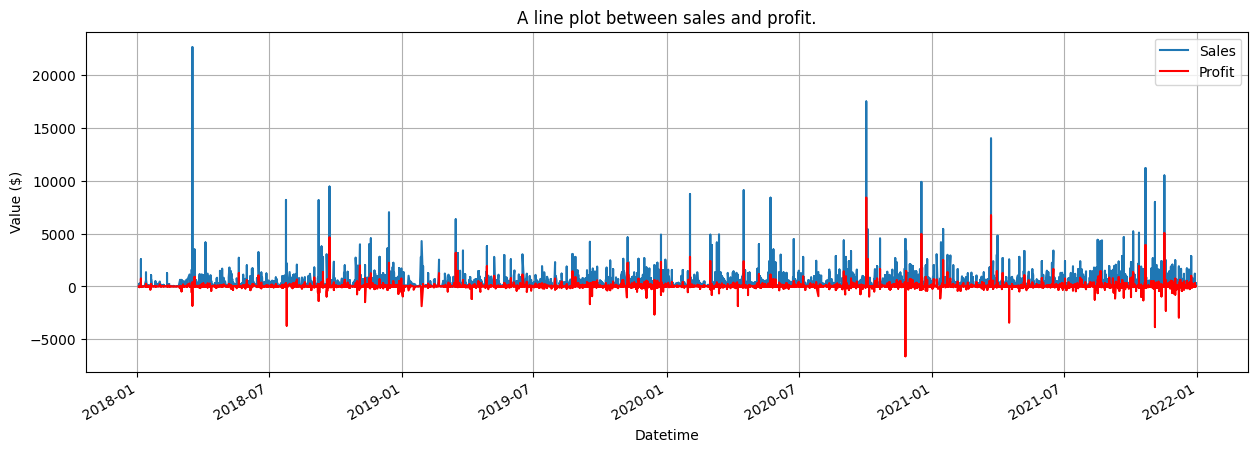

In [7]:
fig, axe = plt.subplots(figsize=(15, 5))
df_sale.plot(x='Order Date', y='Sales', ax = axe)
df_sale.plot(x='Order Date', y='Profit', color ="red", ax = axe)
axe.set_ylabel("Value ($)")
axe.set_xlabel("Datetime")
axe.set_title("A line plot between sales and profit.")
axe.grid()
plt.show()

### 2.1.4 Group data by month

In [8]:
df_sale_m = pd.DataFrame(df_sale.groupby(df_sale['Order Date'].dt.strftime('%Y-%m'))['Sales'].sum())
df_sale_m["Profit"] = df_sale.groupby(df_sale['Order Date'].dt.strftime('%Y-%m'))['Profit'].sum()
df_sale_m.reset_index()
df_sale_m['Cost'] = df_sale_m['Sales'] - df_sale_m['Profit']
df_sale_m.sort_values(by='Order Date', inplace=True)
df_sale_m.index = pd.to_datetime(df_sale_m.index)
display(df_sale_m.head())

print(f"Number of months: {df_sale_m.count().iloc[0]}")

,Sales,Profit,Cost
Order Date,,,
2018-01-01,14236.895,2450.1907,11786.7043
2018-02-01,4519.892,862.3084,3657.5836
2018-03-01,55691.009,498.7299,55192.2791
2018-04-01,28295.345,3488.8352,24806.5098
2018-05-01,23648.287,2738.7096,20909.5774


Number of months: 48


Plot data

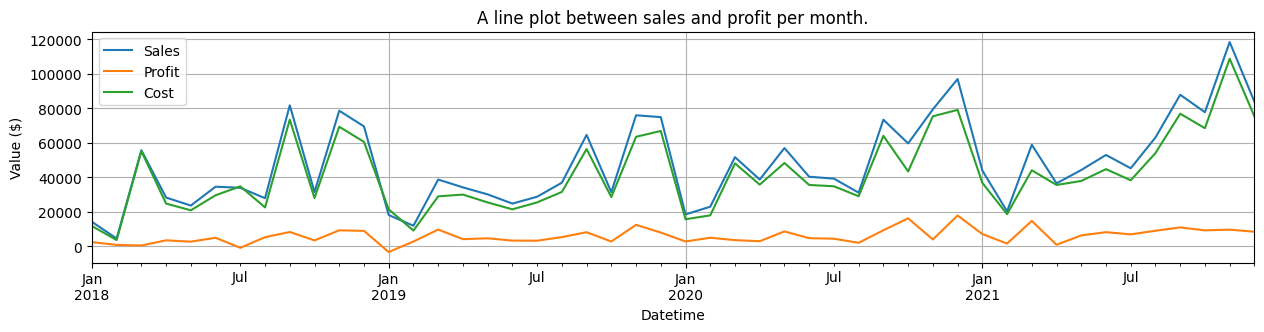

In [9]:
fig, axe = plt.subplots(figsize=(15, 3))
df_sale_m.plot(ax = axe)
axe.set_ylabel("Value ($)")
axe.set_xlabel("Datetime")
axe.set_title("A line plot between sales and profit per month.")
axe.grid()
plt.show()

### 2.1.5 Decomposition

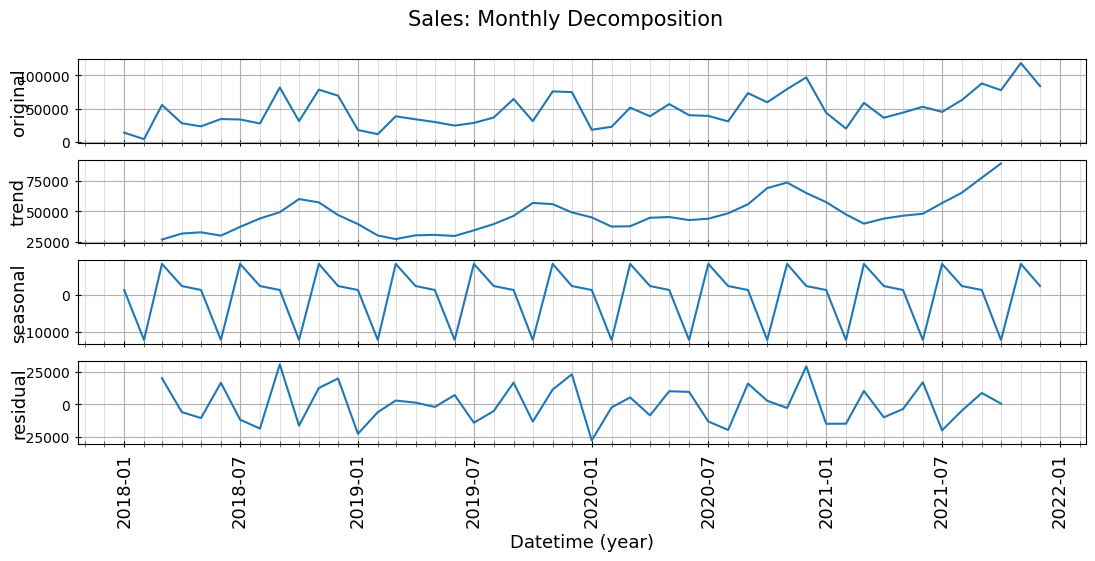

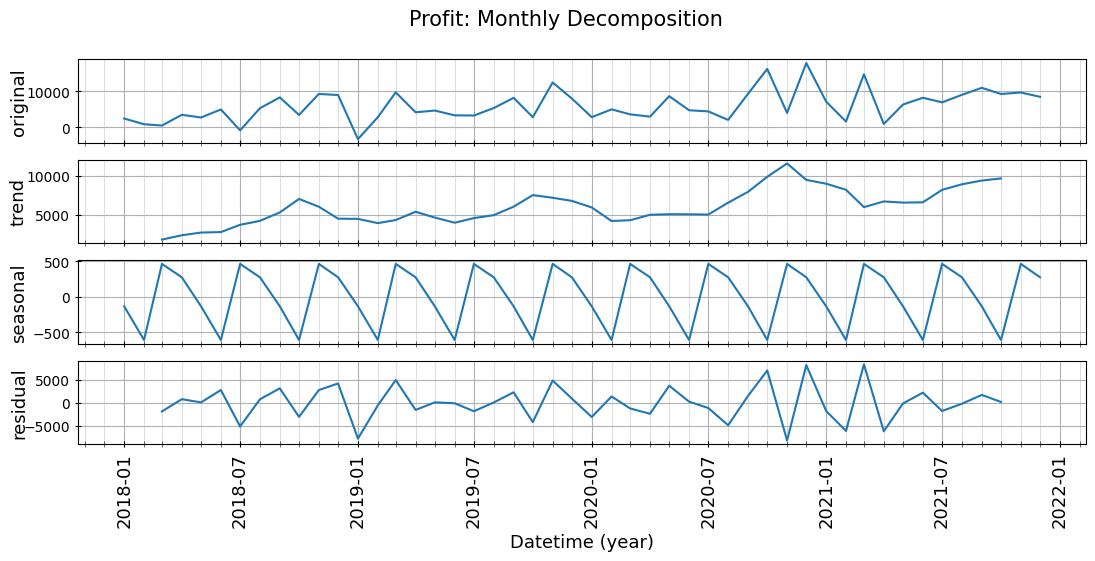

In [10]:
fig, axe = decompositionAnalysis(df_sale_m, "Sales")
plt.show()
fig, axe = decompositionAnalysis(df_sale_m, "Profit")
plt.show()

## 2.2 Prediction: Overall

In [11]:
df_model = df_sale_m.reset_index("Order Date")
df_model.head()

,Order Date,Sales,Profit,Cost
0,2018-01-01,14236.895,2450.1907,11786.7043
1,2018-02-01,4519.892,862.3084,3657.5836
2,2018-03-01,55691.009,498.7299,55192.2791
3,2018-04-01,28295.345,3488.8352,24806.5098
4,2018-05-01,23648.287,2738.7096,20909.5774


### 2.2.1 Sales

#### 2.2.1.1 Plot pacf and acf

Sales: (-4.493767844002665, 0.00020180198458237758, 0, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 848.774903223632)
Sales:Is series stationary? True


(<Figure size 1500x500 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Partial Autocorrelation for Sales'}>,
        <AxesSubplot: title={'center': 'Autocorrelation for Sales'}>],
       dtype=object))

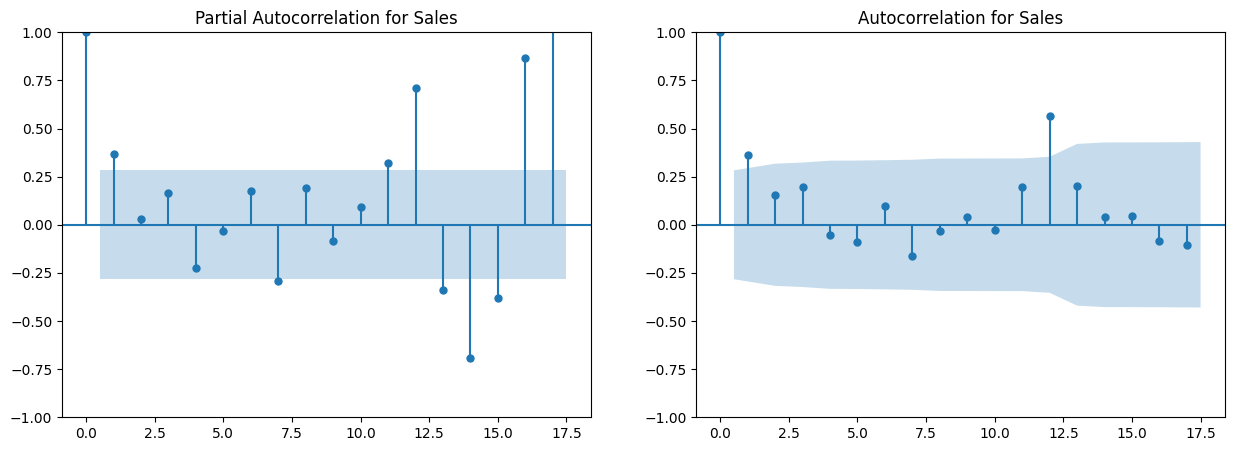

In [53]:
test_timestep=12
predict_timestep=12
f = predict_timeseries(
    df_model, "Sales", "Order Date", 
    test_timestep=test_timestep, predict_timestep=predict_timestep)

# Plot pacf and acf
f.plotTSA(lags=17)

#### 2.2.1.2 LSTM

In [54]:
# Search LSTM
# lags = [1, 2, 3, 4, 5]
# layer_size = [(150, )*2, (200, )*2, (250, )*2, (300, )*2]
lags = [5]
layer_size = [(200, )*2]
for lag in lags:
    for layer in layer_size:
        f.lstm(
            name=f'lstm_{lag}lags_{layer}layer',
            lags=lag,
            epochs=100, 
            lstm_layer_sizes=layer,
            dropout=(0, )*2,
            learning_rate=0.001,
            validation_split=0.2,
            batch_size=32)
        plt.show()
clear_output()  # Just clear output of training

#### 2.2.1.3 Arima

In [55]:
f.arima()

#### 2.2.1.4 Holt winters

In [56]:
f.holtwinters()

#### 2.2.1.5 Prophet

In [57]:
f.prophet()

21:22:43 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:45 - cmdstanpy - INFO - Chain [1] start processing
21:22:46 - cmdstanpy - INFO - Chain [1] done processing


#### 2.2.1.6 Plot Result

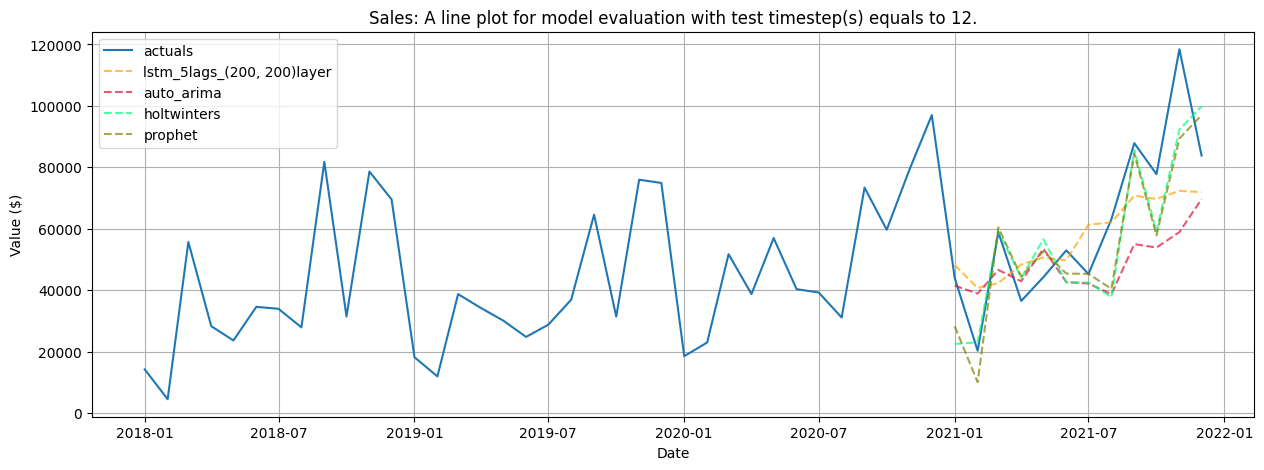

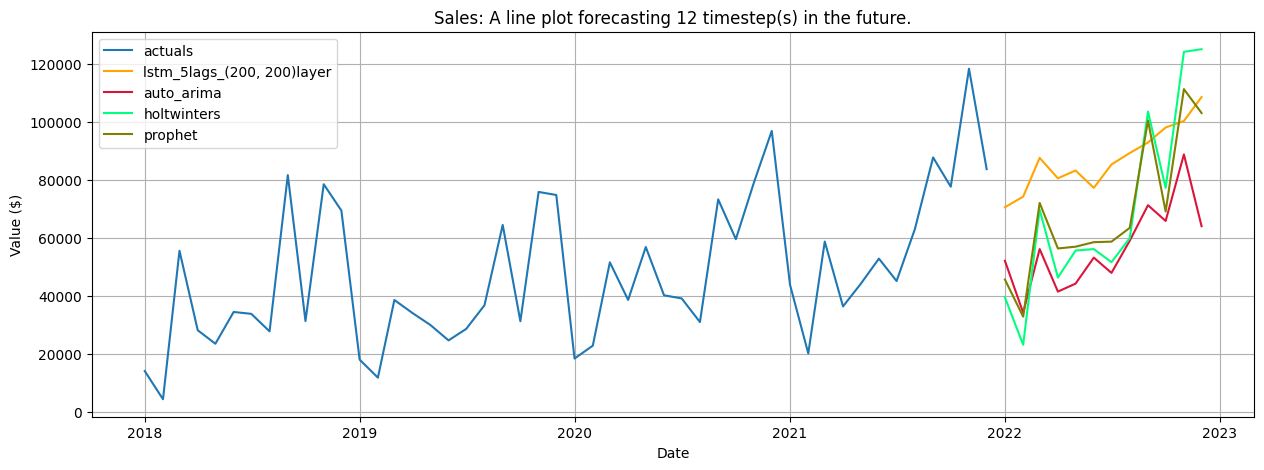

In [58]:
# f.holtwinters()
# f.prophet()

# Plot result
axe = f.plotTrain()
plt.show()

# Plot future
axe = f.plotFuture()
plt.show()

#### 2.2.1.7 Plot metrics

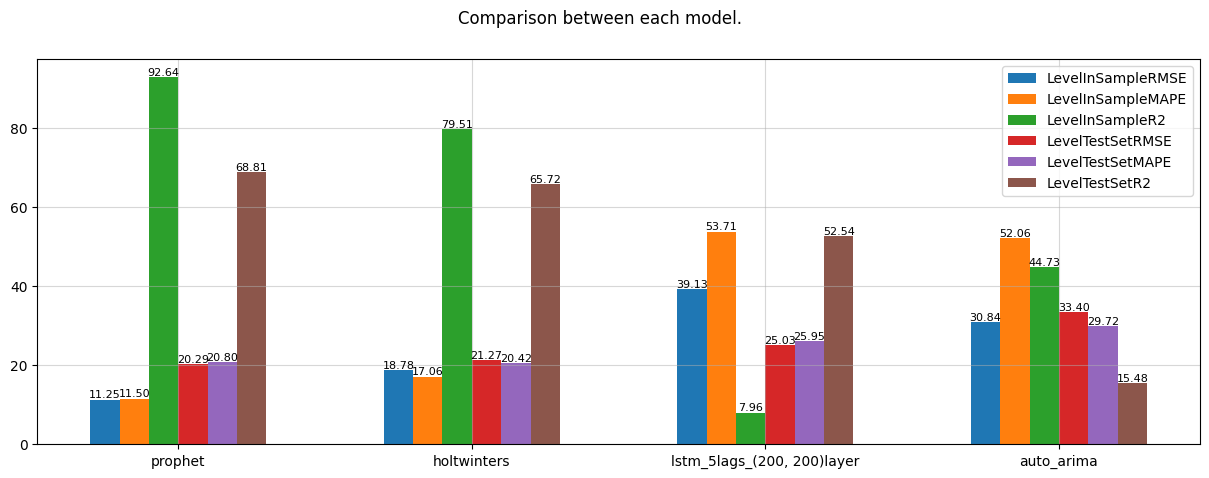

In [59]:
df_plot = f.eval()
df_plot['LevelTestSetRMSE'] = convertToPercentage(df_plot, 'LevelTestSetRMSE')
df_plot['LevelInSampleRMSE'] = convertToPercentage(df_plot, 'LevelInSampleRMSE')
fig, axe = plotMetric(df_plot, width=0.1)
plt.show()

In [60]:
f.eval()

,LevelInSampleRMSE,LevelInSampleMAPE,LevelInSampleR2,LevelTestSetRMSE,LevelTestSetMAPE,LevelTestSetR2
ModelNickname,,,,,,
prophet,6762.715680,11.500422,92.642569,14393.803074,20.800755,68.810770
holtwinters,11285.568651,17.056379,79.510524,15089.671140,20.422249,65.722188
"lstm_5lags_(200, 200)layer",23519.924717,53.709436,7.960842,17755.785760,25.953353,52.539388
auto_arima,18535.997298,52.060814,44.726640,23694.572615,29.723590,15.481593


### 2.2.2 Profits

#### 2.2.2.1 Plot pacf and acf

Profit: (-2.8284747886822363, 0.05432005483966998, 3, 44, {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}, 727.2269795912791)
Profit:Is series stationary? False


(<Figure size 1500x500 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Partial Autocorrelation for Profit'}>,
        <AxesSubplot: title={'center': 'Autocorrelation for Profit'}>],
       dtype=object))

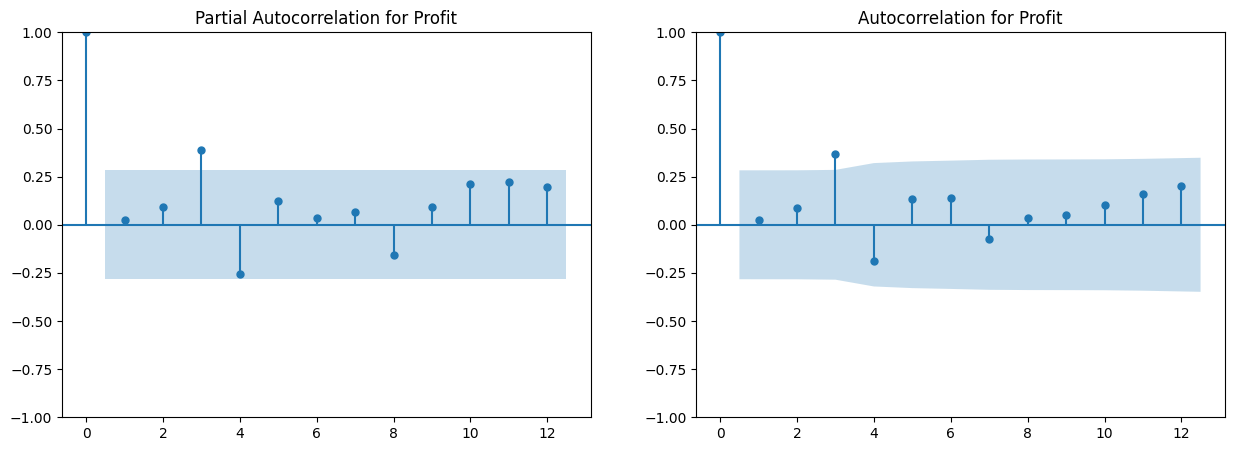

In [45]:
f = predict_timeseries(
    df_model, "Profit", "Order Date", 
    test_timestep=12, predict_timestep=12)

# Plot pacf and acf
f.plotTSA()

#### 2.2.2.2 LSTM

In [46]:
# Search LSTM
# lags = [1, 2, 3, 4, 5]
# layer_size = [(150, )*2, (200, )*2, (250, )*2, (300, )*2]
lags = [5]
layer_size = [(200, )*2]
for lag in lags:
    for layer in layer_size:
        f.lstm(
            name=f'lstm_{lag}lags_{layer}layer',
            lags=lag,
            epochs=100, 
            lstm_layer_sizes=layer,
            dropout=(0, )*2,
            learning_rate=0.001,
            validation_split=0.2,
            batch_size=32)
        plt.show()
clear_output()  # Just clear output of training

#### 2.2.2.3 Arima

In [47]:
f.arima()

#### 2.2.2.4 Holt winters

In [48]:
f.holtwinters()

#### 2.2.2.5 Prophet

In [49]:
f.prophet()

21:22:06 - cmdstanpy - INFO - Chain [1] start processing
21:22:06 - cmdstanpy - INFO - Chain [1] done processing
21:22:07 - cmdstanpy - INFO - Chain [1] start processing
21:22:07 - cmdstanpy - INFO - Chain [1] done processing


#### 2.2.2.6 Plot Result

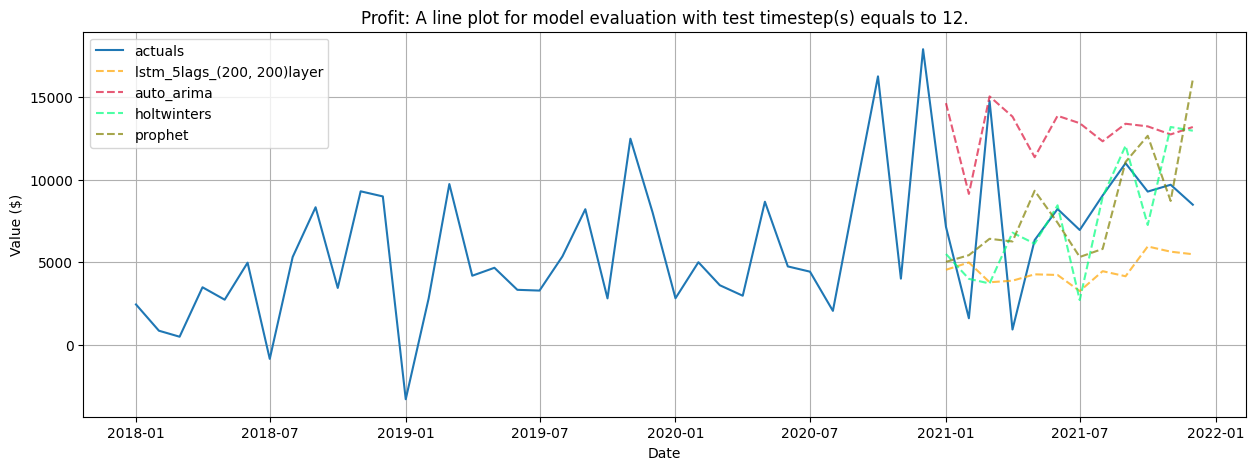

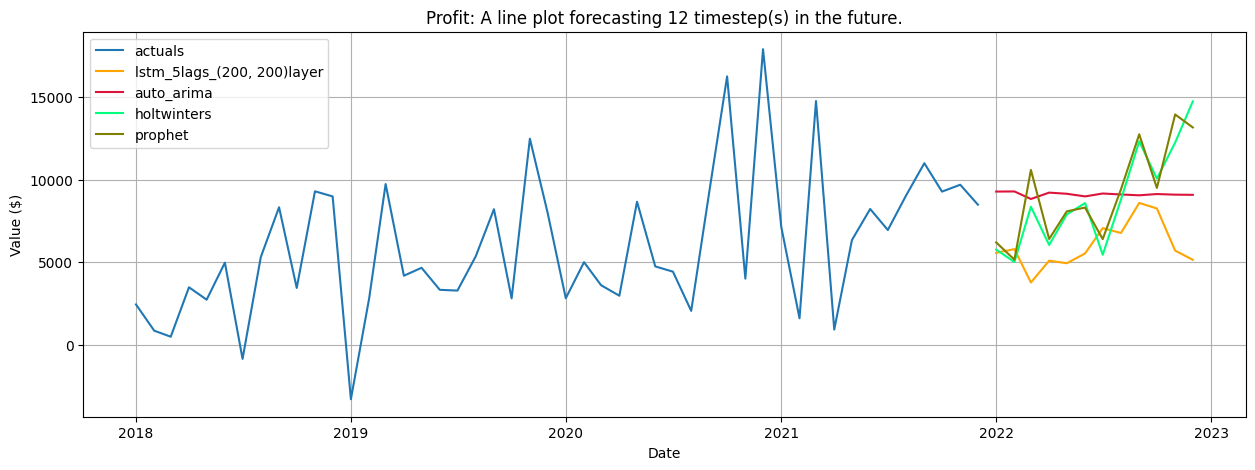

In [50]:
# f.holtwinters()
# f.prophet()

# Plot result
axe = f.plotTrain()
plt.show()

# Plot future
axe = f.plotFuture()
plt.show()

#### 2.2.2.7 Plot metrics

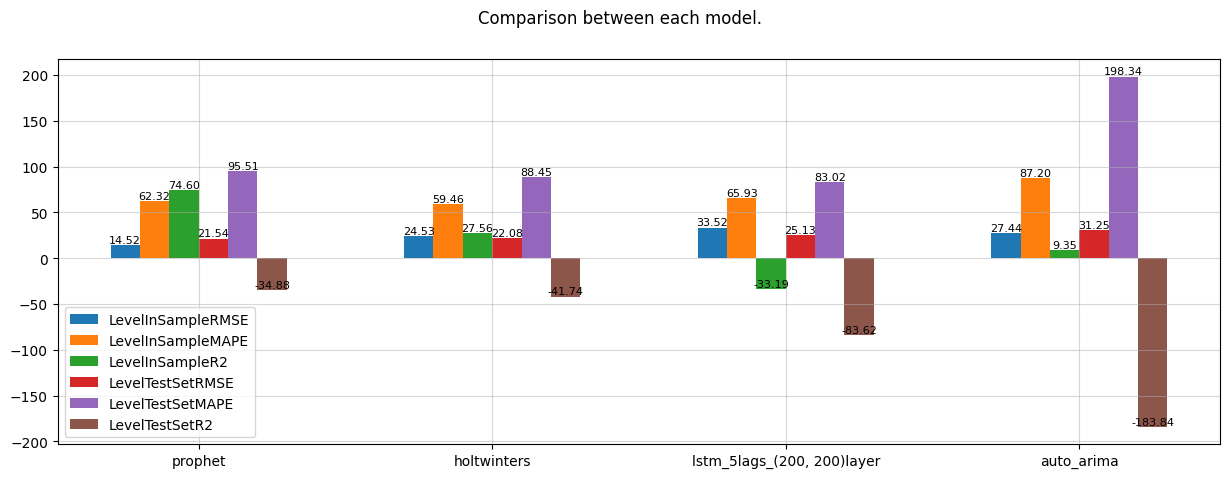

In [51]:
df_plot = f.eval()
df_plot['LevelTestSetRMSE'] = convertToPercentage(df_plot, 'LevelTestSetRMSE')
df_plot['LevelInSampleRMSE'] = convertToPercentage(df_plot, 'LevelInSampleRMSE')
fig, axe = plotMetric(df_plot, width=0.1)
plt.show()

In [52]:
f.eval()

,LevelInSampleRMSE,LevelInSampleMAPE,LevelInSampleR2,LevelTestSetRMSE,LevelTestSetMAPE,LevelTestSetR2
ModelNickname,,,,,,
prophet,2139.010718,62.320420,74.595061,4175.947834,95.505925,-34.882075
holtwinters,3612.080618,59.463364,27.555220,4280.737582,88.450440,-41.736375
"lstm_5lags_(200, 200)layer",4936.129848,65.931177,-33.191421,4872.298981,83.022009,-83.616612
auto_arima,4040.595698,87.198641,9.346824,6057.749885,198.343574,-183.835548


## 2.3 Prediction: By Category

In [26]:
df_model_cat = pd.DataFrame(df_sale.groupby([df_sale['Order Date'].dt.strftime('%Y-%m'), 'Category']).sum())
df_model_cat = df_model_cat.reset_index(['Order Date', 'Category'])
df_model_cat

,Order Date,Category,Profit,Quantity,Sales
0,2018-01,Furniture,805.4665,70,6242.5250
1,2018-01,Office Supplies,788.9506,169,4851.0800
2,2018-01,Technology,855.7736,45,3143.2900
3,2018-02,Furniture,120.6917,23,1839.6580
4,2018-02,Office Supplies,176.0910,103,1071.7240
...,...,...,...,...,...
139,2021-11,Office Supplies,3609.1029,1093,31472.3370
140,2021-11,Technology,5674.9371,383,49918.7730
141,2021-12,Furniture,1146.7548,394,31407.4668
142,2021-12,Office Supplies,1774.3132,1061,30436.9420


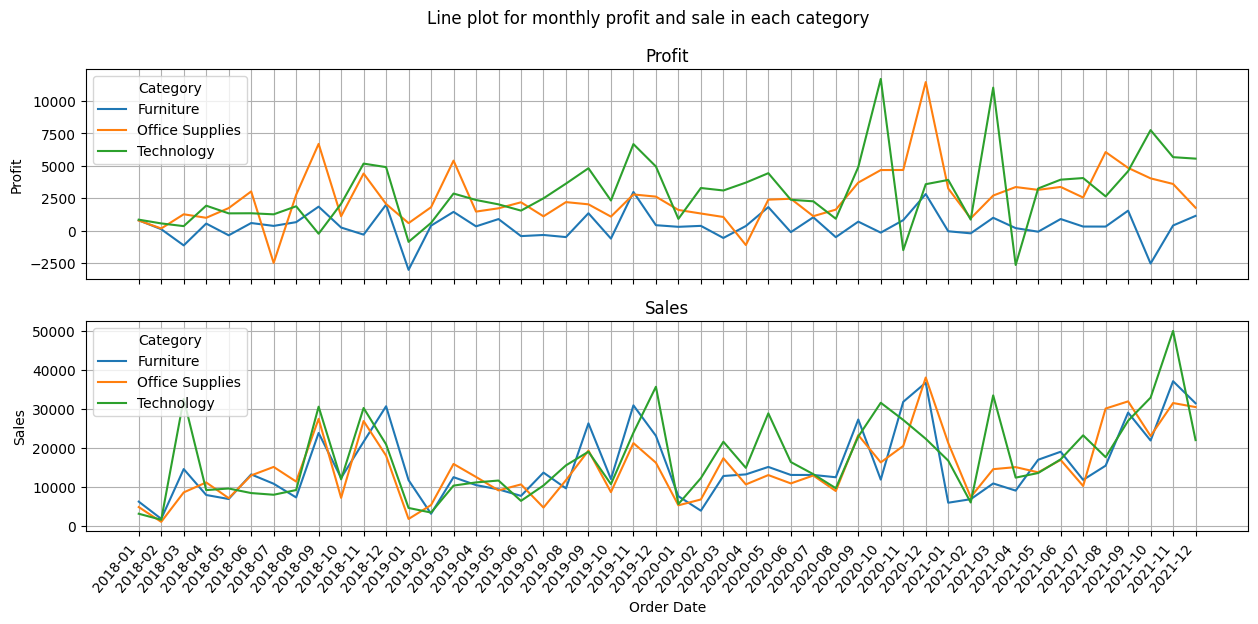

In [27]:
row_num = df_model_cat.groupby('Category').count().iloc[0]['Order Date']

fig, axe = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
fig.suptitle('Line plot for monthly profit and sale in each category')

plotLine(df_model_cat, axe[0], 'Order Date', 'Profit', hue='Category')
plotLine(df_model_cat, axe[1], 'Order Date', 'Sales', hue='Category')

plt.show()

In [28]:
# Seperate into 3 dataframes
df_model_furn = df_model_cat[df_model_cat['Category']=='Furniture']
df_model_offc = df_model_cat[df_model_cat['Category']=='Office Supplies']
df_model_tech = df_model_cat[df_model_cat['Category']=='Technology']

df_model_cat_dict = {
    'Furniture': df_model_furn,
    'Office Supplies': df_model_offc,
    'Technology': df_model_tech
}

### 2.3.1 Sales

#### 2.3.1.1 Plot pacf and acf

Profit: (-5.084572329368871, 1.5055717682107484e-05, 4, 43, {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}, 624.5601686940499)
Profit:Is series stationary? True
Profit: (-5.301589284652396, 5.434298590870671e-06, 0, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 669.0420879490264)
Profit:Is series stationary? True
Profit: (-7.253557790443203, 1.7544917896675799e-10, 0, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 695.3184324192205)
Profit:Is series stationary? True


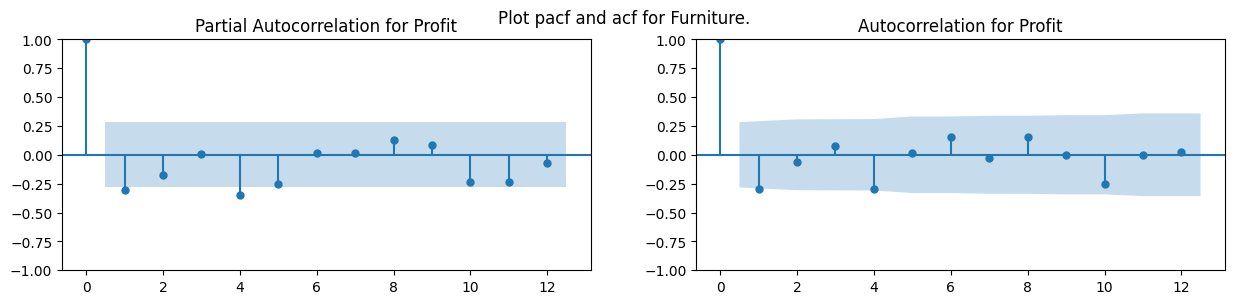

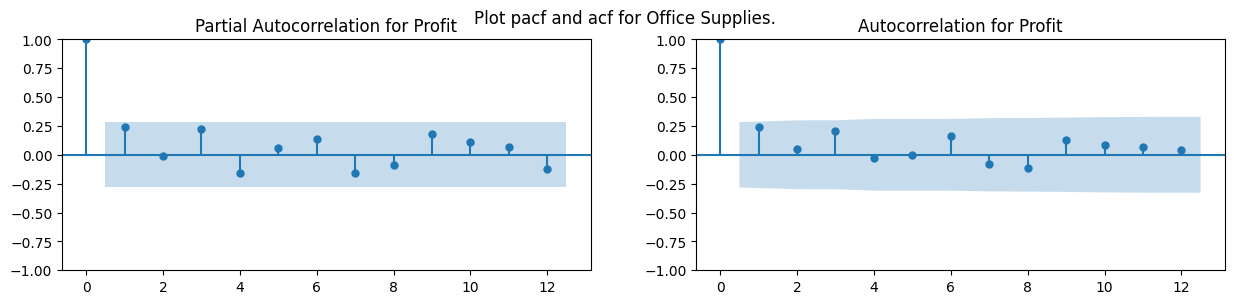

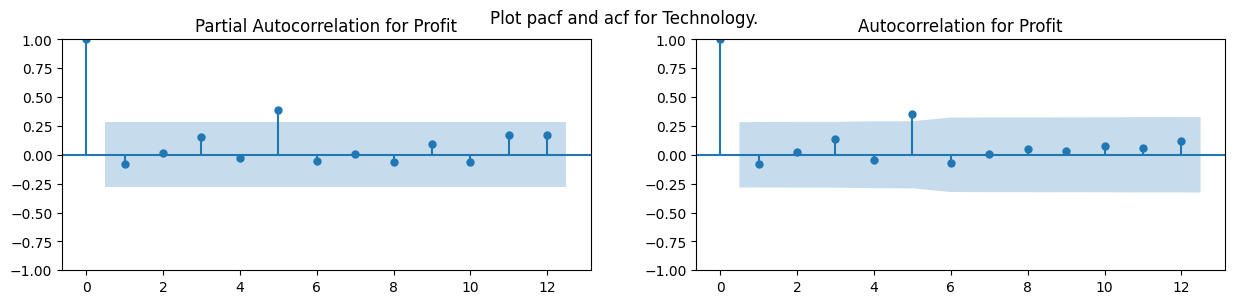

In [36]:
test_timestep=12
predict_timestep=12
f_list = {}
for key, df in df_model_cat_dict.items():
    f_list[key] = predict_timeseries(
        df_model_cat_dict[key], "Profit", "Order Date", 
        test_timestep=test_timestep, predict_timestep=predict_timestep)

    fig, axe = f_list[key].plotTSA(figsize=(15, 3))
    fig.suptitle(f'Plot pacf and acf for {key}.')

#### 2.3.1.2 LSTM

In [37]:
# Search LSTM
for key, df in df_model_cat_dict.items():
    # lags = [1, 2, 3, 4, 5]
    # layer_size = [(150, )*2, (200, )*2, (250, )*2, (300, )*2]
    lags = [5]
    layer_size = [(200, )*2]
    for lag in lags:
        for layer in layer_size:
            f_list[key].lstm(
                name=f'lstm_{lag}lags_{layer}layer',
                lags=lag,
                epochs=100, 
                lstm_layer_sizes=layer,
                dropout=(0, )*2,
                learning_rate=0.001,
                validation_split=0.2,
                batch_size=32)
            plt.show()
    clear_output()  # Just clear output of training

#### 2.3.1.3 Arima

In [38]:
for key, df in df_model_cat_dict.items():
    f_list[key].arima()

#### 2.3.1.4 Holt winters

In [39]:
for key, df in df_model_cat_dict.items():
    f_list[key].holtwinters()

#### 2.3.1.5 Prophet

In [40]:
for key, df in df_model_cat_dict.items():
    f_list[key].prophet()

17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1] done processing


#### 2.3.1.6 Plot Result

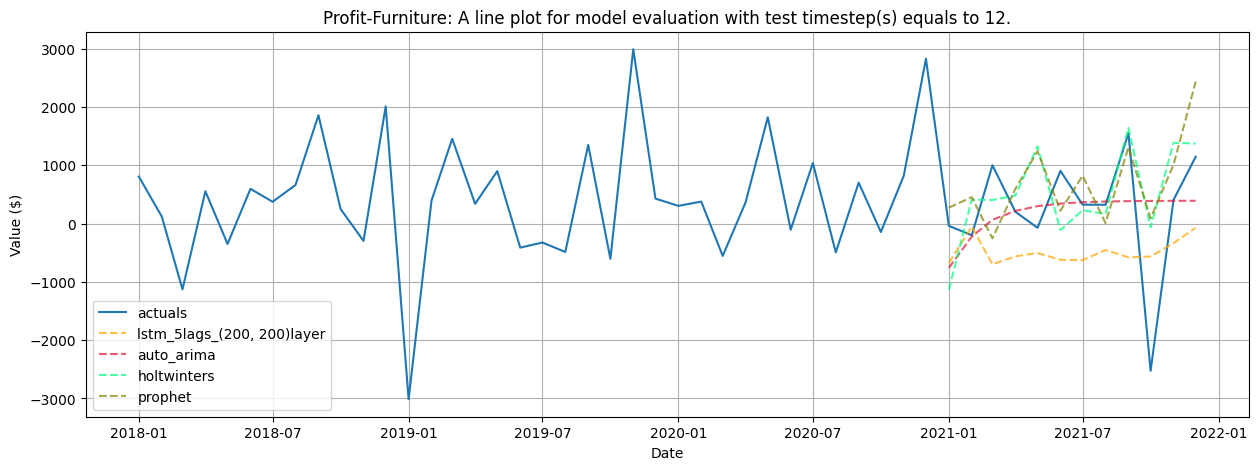

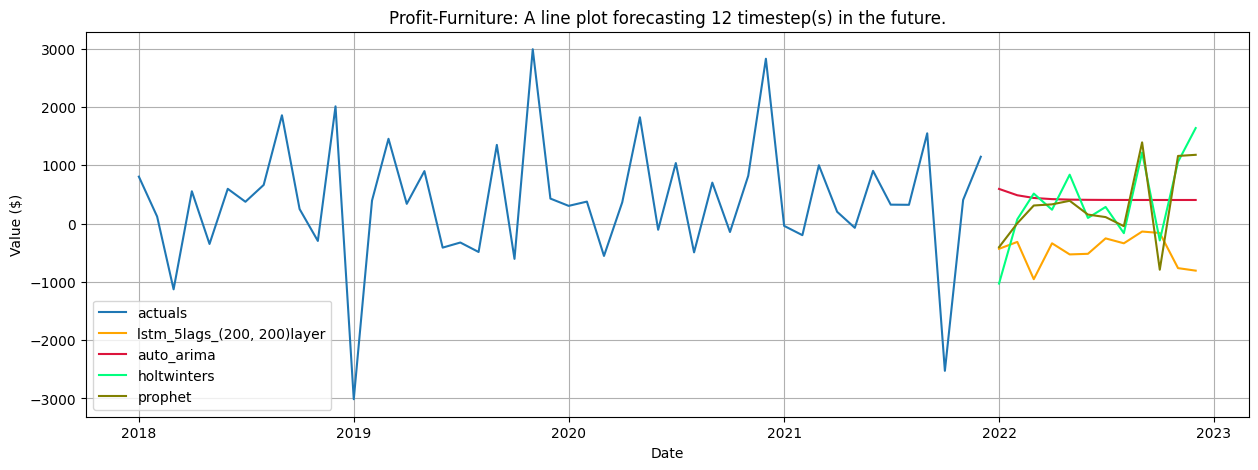

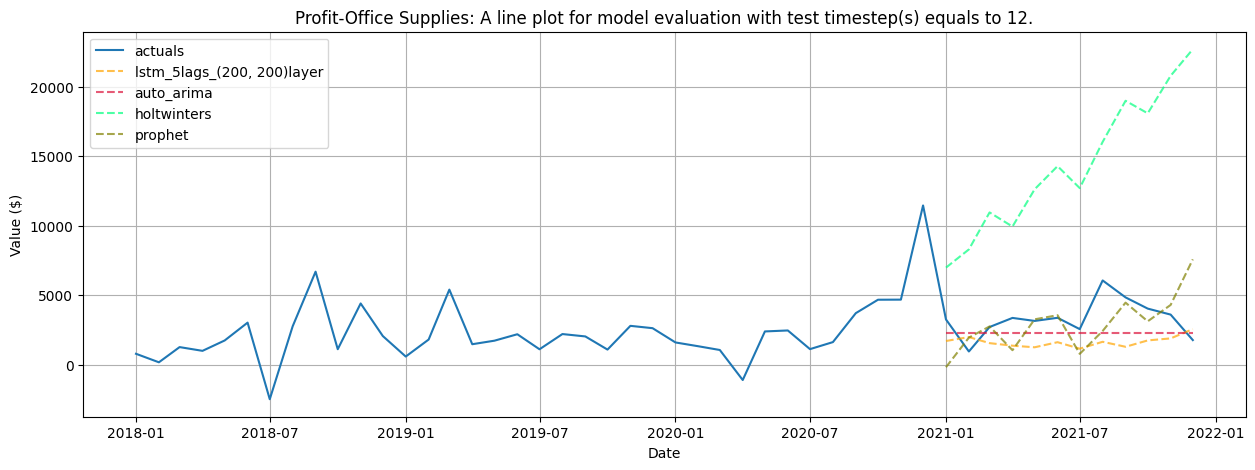

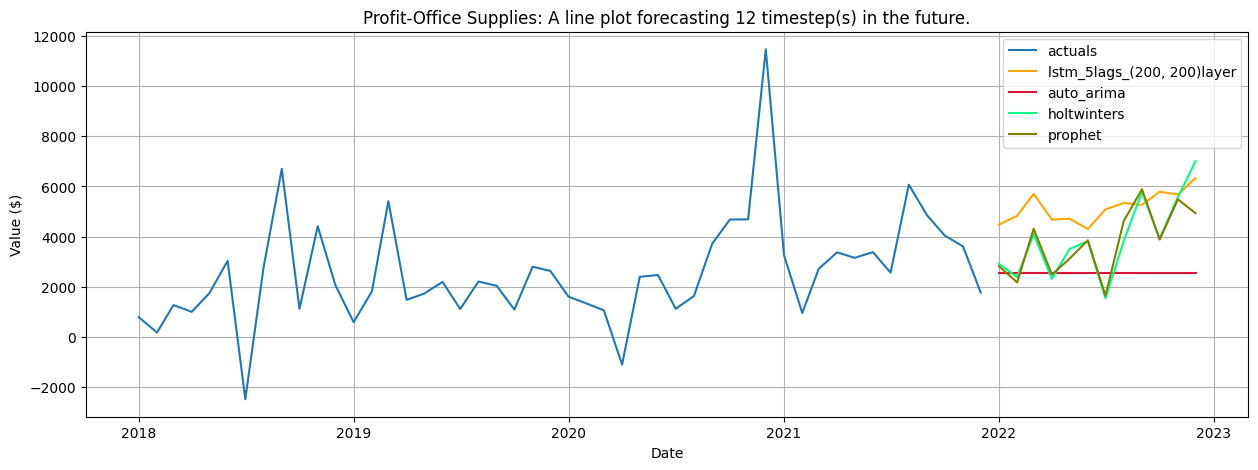

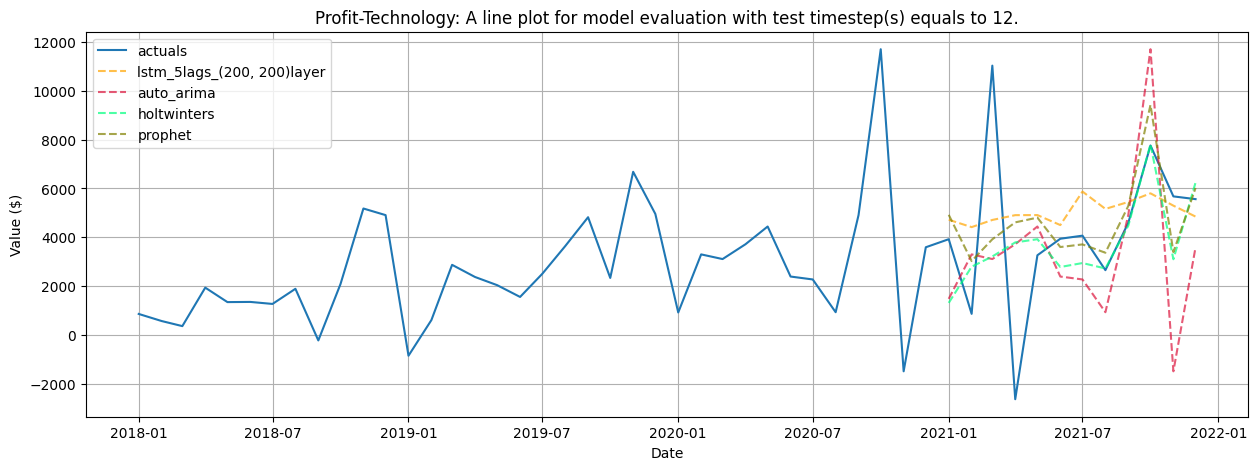

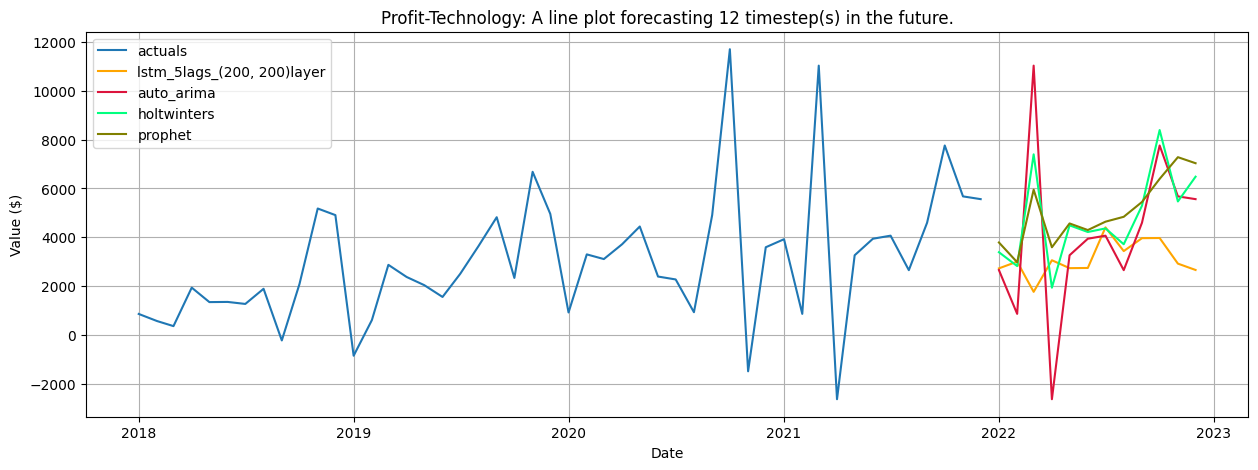

In [43]:
for key, df in df_model_cat_dict.items():
    # Plot result
    axe = f_list[key].plotTrain()
    axe.set_title(f"Profit-{key}: A line plot for model evaluation with test timestep(s) equals to {test_timestep}.")
    plt.show()

    # Plot future
    axe = f_list[key].plotFuture()
    axe.set_title(f"Profit-{key}: A line plot forecasting {predict_timestep} timestep(s) in the future.")
    plt.show()

#### 2.3.1.7 Plot metrics

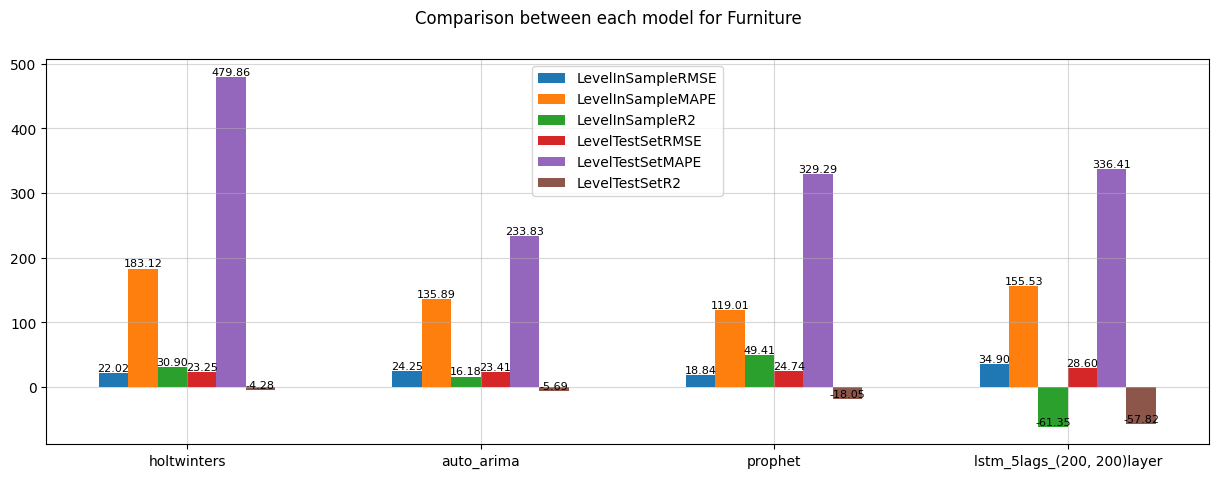

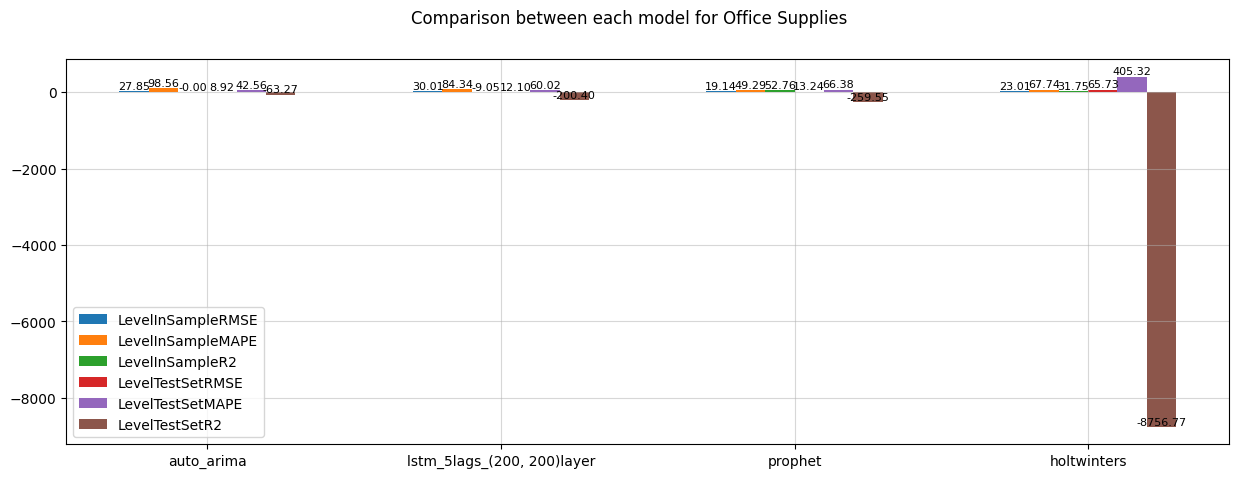

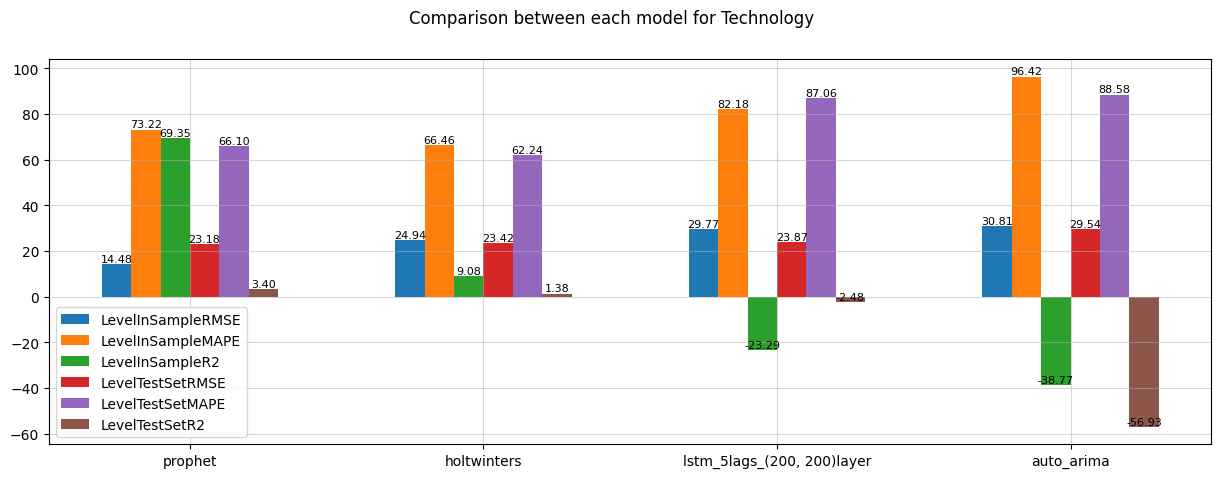

In [42]:
for key, df in df_model_cat_dict.items():
    df_plot = f_list[key].eval()
    df_plot['LevelTestSetRMSE'] = convertToPercentage(df_plot, 'LevelTestSetRMSE')
    df_plot['LevelInSampleRMSE'] = convertToPercentage(df_plot, 'LevelInSampleRMSE')
    fig, axe = plotMetric(df_plot, width=0.1)
    fig.suptitle(f"Comparison between each model for {key}")
    plt.show()